# Netflix Recommendation System

In [ ]:
import os
import sys
import textwrap
from collections import defaultdict

import numpy as np
import pandas as pd
import time
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt

import cornac
from cornac.utils import cache
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from concurrent.futures import ThreadPoolExecutor
from itertools import product
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from collections import defaultdict
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, mean_squared_error, mean_absolute_error

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False

System version: 3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)]
Cornac version: 2.3.0


## Exploring the Data

In [20]:
feedback = cornac.datasets.netflix.load_feedback(fmt='UIR', variant='small')

In [21]:
print('Type of dataset:', type(feedback))
print('Entry example:', feedback[0])

Type of dataset: <class 'list'>
Entry example: ('2567280', '2', 3.0)


In [22]:
df = pd.DataFrame(feedback, columns=['userid', 'itemid', 'rating'])
df['userid'] = df['userid'].astype(int)  
df['itemid'] = df['itemid'].astype(int)
df['rating'] = df['rating'].astype(float)

In [23]:
sns.set(style='whitegrid')

# Count ratings by item and sort
item_counts = df.groupby('itemid')['rating'].count().sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.lineplot(data=item_counts, linewidth=2)
plt.yscale('log') 
plt.xticks([], [])

plt.xlabel('Items')
plt.ylabel('Number of ratings (log)')
plt.title('Distribution of Ratings by Item')
plt.tight_layout()
plt.show()

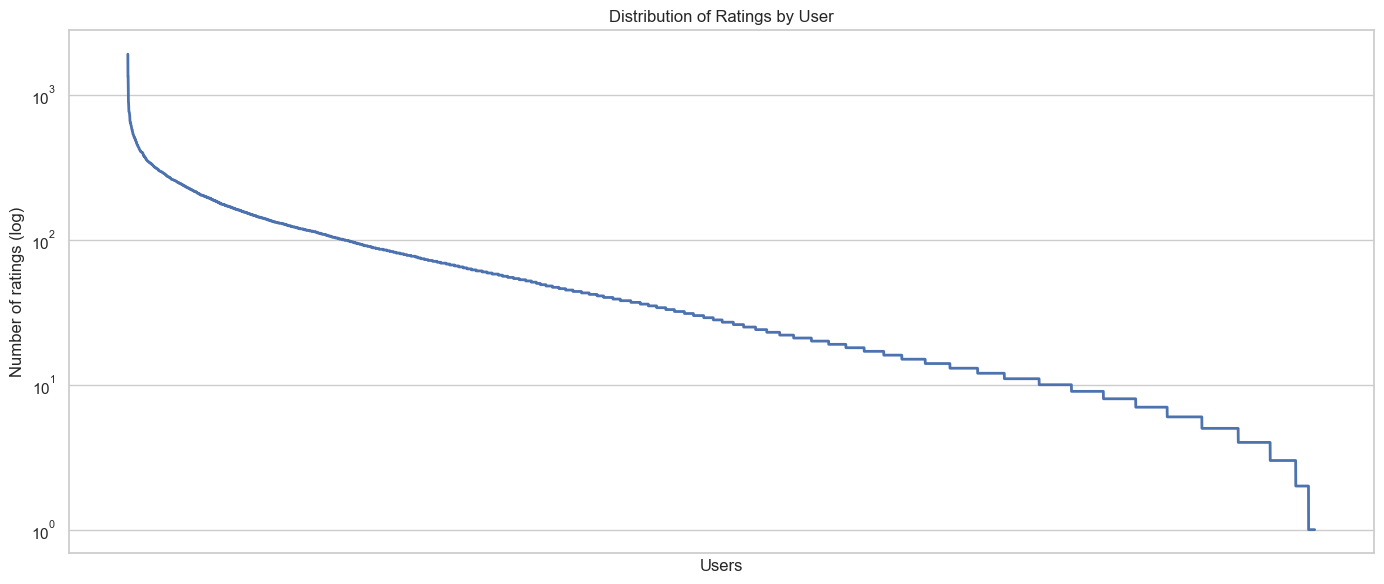

In [24]:
sns.set(style='whitegrid')

# Count ratings by user and sort
user_counts = df.groupby('userid')['rating'].count().sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.lineplot(data=user_counts, linewidth=2)
plt.yscale('log')

plt.xlabel('Users')
plt.ylabel('Number of ratings (log)')
plt.title('Distribution of Ratings by User')

plt.xticks([], [])

plt.tight_layout()
plt.show()


In [25]:
# Data sparsity, a mesure of how much data we do not observe
n_users = df.userid.nunique()
n_items = df.itemid.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"Sparsity: {sparsity * 100.0:.2f}%")

Number of users: 9992
Number of items: 4945
Number of available ratings: 607803
Number of all possible ratings: 49410440
----------------------------------------
Sparsity: 98.77%


## User-Based and Item-Based Recommendations

User-based and item-based collaborative filtering methods are intuitive approaches that use similarities between users or items to generate recommendations. These methods are useful as they require no prior knowledge about the items and can adapt dynamically to user preferences.

In [26]:
metrics = [cornac.metrics.RMSE(), 
           cornac.metrics.MAE(),
           cornac.metrics.Precision(k=10),
           cornac.metrics.Recall(k=10),
           cornac.metrics.NDCG(k=10)
]

### User-Based

In [27]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)

ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=metrics,
).run()


TEST:
...
                   |    MAE |   RMSE | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
UserKNN-Cosine     | 0.7701 | 0.8771 |  0.0001 |       0.0001 |    0.0000 |    5.7748 | 217.0818
UserKNN-Cosine-MC  | 0.7671 | 0.8751 |  0.0000 |       0.0000 |    0.0000 |    8.0821 | 223.5769
UserKNN-Pearson    | 0.7671 | 0.8751 |  0.0000 |       0.0000 |    0.0000 |    5.4736 | 218.6725
UserKNN-Pearson-MC | 0.7671 | 0.8751 |  0.0000 |       0.0000 |    0.0000 |    5.1349 | 221.4064



### Item-Based

In [28]:
# ItemKNN methods
K = 50  # number of nearest neighbors
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=metrics
).run()


TEST:
...
                       |    MAE |   RMSE | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
---------------------- + ------ + ------ + ------- + ------------ + --------- + --------- + --------
ItemKNN-Cosine         | 0.8120 | 0.9225 |  0.0027 |       0.0035 |    0.0016 |    1.4279 | 176.7565
ItemKNN-Pearson        | 0.8041 | 0.9103 |  0.0002 |       0.0002 |    0.0001 |    1.3944 | 183.2454
ItemKNN-Pearson-MC     | 0.7964 | 0.9040 |  0.0011 |       0.0013 |    0.0010 |    1.5832 | 181.7791
ItemKNN-AdjustedCosine | 0.7683 | 0.8749 |  0.0060 |       0.0070 |    0.0039 |    1.3446 | 179.1186



### Making Recommendations

In [29]:
# Obtain all user ids and item ids from the interactions
user_ids = set()
item_ids = set()

# Each interaction is a tuple (user id, item id, rating)
for interaction in feedback:
    user_ids.add(interaction[0])  
    item_ids.add(interaction[1])  

user_ids = list(user_ids)
item_ids = list(item_ids)

#### Top 10 Recommendations

In [30]:
# Top 10 global items by number of interactions

item_interactions = {}

for interaction in feedback:
    item_id = interaction[1]
    item_interactions[item_id] = item_interactions.get(item_id, 0) + 1

# Sort items by interactions
sorted_items = sorted(item_interactions.items(), key=lambda x: x[1], reverse=True)

top_10_items = sorted_items[:10]
print(f"Top 10 items by number of interactions: {top_10_items}")

top_10_items = [sublist[0] for sublist in top_10_items]

Top 10 items by number of interactions: [('15124', 4692), ('15205', 4195), ('16377', 3910), ('6037', 3368), ('11064', 3283), ('7624', 3280), ('14367', 3280), ('4306', 3268), ('4996', 3249), ('12232', 3215)]


In [31]:
# Create dictionaries (user id: list of recommendations) for both methods, using the optimal models
uknn_recommendations = dict()
iknn_recommendations = dict()

for i in user_ids:
    if uknn_pearson.uid_map.get(i, -1) != -1:
        uknn_recommendations[i] = uknn_pearson.recommend(i, k = 10)  # Top 10 user-based recommendations
    else:
        uknn_recommendations[i] = top_10_items
    if iknn_adjusted.uid_map.get(i, -1) != -1:
        iknn_recommendations[i] = iknn_adjusted.recommend(i, k = 10)  # Top 10 item-based recommendations
    else:
        iknn_recommendations[i] = top_10_items

In [32]:
print('User-based recommendations:', uknn_recommendations)
print('Item-based recommendations:', iknn_recommendations)

User-based recommendations: {'1308854': ['8546', '13455', '3836', '9026', '12544', '14914', '1127', '4875', '13332', '2799'], '2395017': ['15602', '3836', '13312', '14406', '16693', '13332', '506', '14543', '14486', '6560'], '1748341': ['5575', '8394', '9755', '6392', '10075', '1127', '11675', '4941', '15254', '2799'], '156979': ['12050', '14914', '1227', '16693', '7276', '2715', '16080', '14159', '17689', '3761'], '2593160': ['8546', '15602', '3964', '12050', '11816', '13312', '10901', '4202', '17615', '16921'], '2592150': ['1127', '15793', '8195', '6392', '14406', '13312', '7353', '15439', '6126', '16921'], '2026118': ['14626', '8546', '5753', '16921', '10070', '2681', '8196', '15412', '16353', '3395'], '2622942': ['10307', '3897', '1127', '13312', '4875', '6340', '15412', '13639', '8368', '17689'], '1676093': ['10307', '3897', '9755', '12050', '3836', '4875', '86', '15793', '2715', '15050'], '621463': ['14626', '5575', '13590', '15793', '12050', '8195', '3836', '5753', '16921', '935

#### Rating Predictions

As the relevance metric of both UKNN and IKNN models is poor, we enrich the recommendation system with the prediction of ratings.

In [33]:
def get_model_errors(model, df):
    real_pairs = zip(df['userid'], df['itemid'])
    predictions = []
    
    for user_id, item_id, real_rating in zip(df['userid'], df['itemid'], df['rating']):
        try:
            score = model.score(user_id, item_id)
            if score is not None:
                predictions.append({
                    'userid': user_id,
                    'itemid': item_id,
                    'real_rating': real_rating,
                    'predected_rating': score,
                    'error': real_rating - score
                })
        except:
            continue
            
    return pd.DataFrame(predictions)

In [34]:
# Create dictionaries (user id: list of predictions) for both methods
uknn_predictions = dict()
iknn_predictions = dict()

def calculate_missing_scores(model, user_ids, item_ids, existing_pairs):
    scores = {}
    for user_id, item_id in product(user_ids, item_ids):
        if (user_id, item_id) not in existing_pairs:
            try:
                score = model.score(user_id, item_id)
                if score is not None:
                    scores[(user_id, item_id)] = score
            except:
                continue  # Ignores errors (not seen users/items)
    return scores

user_ids = df['userid'].unique()  
item_ids = df['itemid'].unique()
existing_pairs = set(zip(df['userid'], df['itemid']))

uknn_scores = calculate_missing_scores(uknn_pearson, user_ids, item_ids, existing_pairs)
iknn_scores = calculate_missing_scores(iknn_adjusted, user_ids, item_ids, existing_pairs)

# Convert to dataframe
df_uknn = pd.DataFrame([(k[0], k[1], v) for k, v in uknn_scores.items()], 
                       columns=['userid', 'itemid', 'uknn_score'])
df_iknn = pd.DataFrame([(k[0], k[1], v) for k, v in iknn_scores.items()], 
                       columns=['userid', 'itemid', 'iknn_score'])

# Combine results
df_scores = pd.merge(df_uknn, df_iknn, on=['userid', 'itemid'], how='outer')


In [35]:
print(df_scores)

       userid  itemid  uknn_score  iknn_score
0        6504       2    3.263747    3.561786
1        6504       3    3.654234    3.348444
2        6504       9    3.711811    3.362902
3        6504      10    3.079386    3.162807
4        6504      12    4.716798    4.378410
...       ...     ...         ...         ...
68724     952    4901    2.464882    3.178102
68725     952    4911    2.464882    3.178102
68726     952    4912    3.400049    3.101926
68727     952    4913    3.239262    3.322707
68728     952    4915    1.958261    3.155575

[68729 rows x 4 columns]


In [36]:
uknn_errors = get_model_errors(uknn_pearson, df)
uknn_errors.head()

userid  itemid  real_rating  predected_rating     error
0    6504      17          3.0          3.799996 -0.799996
1    6092      28          5.0          3.584874  1.415126
2    9861      28          4.0          2.089052  1.910948
3    6504      28          4.0          3.601166  0.398834
4    3495      46          3.0          2.609470  0.390530

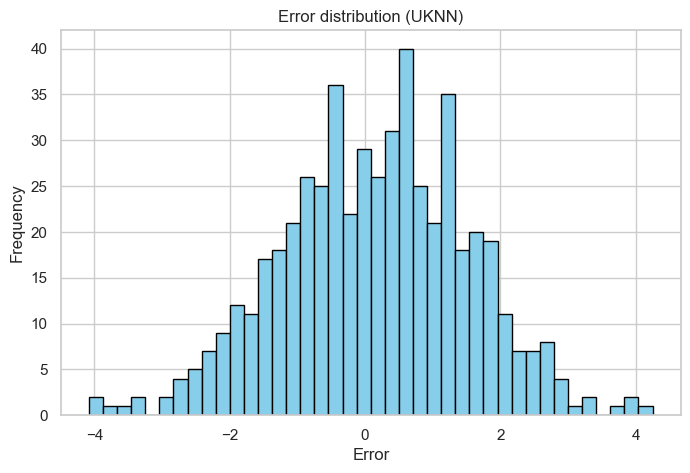

In [37]:
# UKNN error histogram

plt.figure(figsize=(8,5))
plt.hist(uknn_errors['error'], bins=40, color='skyblue', edgecolor='black')
plt.title('Error distribution (UKNN)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [38]:
iknn_errors = get_model_errors(iknn_adjusted, df)
iknn_errors.head()

userid  itemid  real_rating  predected_rating     error
0    6504      17          3.0          3.670015 -0.670015
1    6092      28          5.0          3.765334  1.234666
2    9861      28          4.0          2.305041  1.694959
3    6504      28          4.0          3.738741  0.261259
4    3495      46          3.0          3.348062 -0.348062

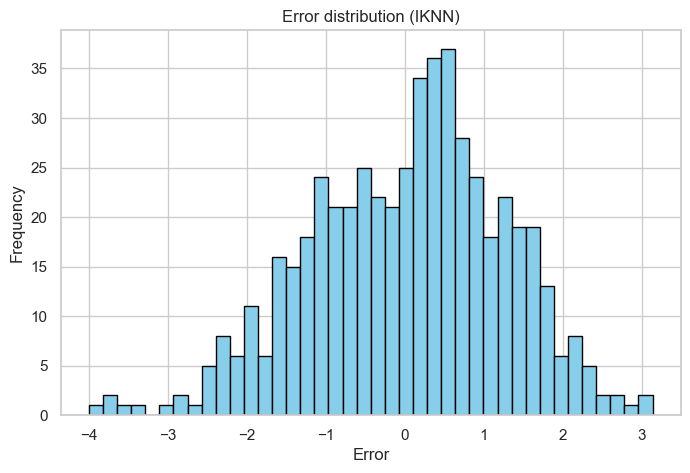

In [39]:
# IKNN error histogram

plt.figure(figsize=(8,5))
plt.hist(iknn_errors['error'], bins=40, color='skyblue', edgecolor='black')
plt.title('Error distribution (IKNN)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## SVD (Singular Value Decomposition)

We will use SVD to build a recommendation system based on latent factors. This approach helps uncover hidden relationships between users and items from existing rating patterns.

In [60]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userid', 'itemid', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

# Train model
algo = SVD()
start_time = time.time()
algo.fit(trainset)
training_time = time.time() - start_time

# Predict ratings
predictions = algo.test(testset)

svd_errors = pd.DataFrame({
    'userid': [pred.uid for pred in predictions],
    'itemid': [pred.iid for pred in predictions],
    'rating_real': [pred.r_ui for pred in predictions],
    'rating_predicho': [pred.est for pred in predictions],
    'error': [pred.r_ui - pred.est for pred in predictions]
})

# Metrics
mae = mean_absolute_error(svd_errors['rating_real'], svd_errors['rating_predicho'])
rmse = np.sqrt(mean_squared_error(svd_errors['rating_real'], svd_errors['rating_predicho']))


In [63]:
print(f"Training time: {training_time:.4f} seconds")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Training time: 8.8685 seconds
MAE: 0.7106
RMSE: 0.9120


In [41]:
user_ids = df['userid'].unique()  
item_ids = df['itemid'].unique()
all_pairs = set(product(user_ids, item_ids))
existing_pairs = frozenset(zip(df['userid'], df['itemid']))

missing_pairs = all_pairs - existing_pairs

def generate_svd_predictions(missing_pairs):
    for user_id, item_id in missing_pairs:
        estimated_rating = algo.predict(user_id, item_id).est
        yield {'userid': user_id, 'itemid': item_id, 'estimated_rating': estimated_rating}

pred_df = pd.DataFrame(generate_svd_predictions(missing_pairs))
print(pred_df.head())

    userid  itemid  estimated_rating
0  2330798   10901          3.129997
1   306973    7756          3.269518
2   253064    1489          3.300317
3  2166063    4510          4.027679
4   975599    8011          4.059872


In [42]:
print(svd_errors.head())

    userid  itemid  rating_real  rating_predicho     error
0   461355   12763          4.0         4.260259 -0.260259
1  2018950   13342          3.0         3.779371 -0.779371
2  1806362   11064          3.0         3.904666 -0.904666
3  2649231   17180          4.0         3.971927  0.028073
4  1048903   12232          3.0         3.802939 -0.802939


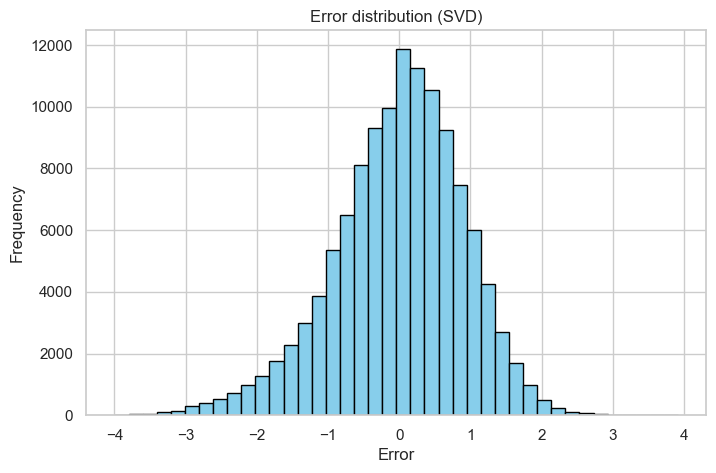

In [43]:
# SVD error histogram

plt.figure(figsize=(8,5))
plt.hist(svd_errors['error'], bins=40, color='skyblue', edgecolor='black')
plt.title('Error distribution (SVD)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Implicit Feedback

We will simulate binary implicit feedback. If the rating is 4 or higher, we generate a positive interaction (1). If the rating is below 4, we generate a negative interaction (0). This simplifies the ratings to binary interactions for implicit recommendation models, focusing on whether a user interacted with an item, regardless of the rating's intensity.

In [44]:
df['interaction'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Map numeric indexes
user_map = {u: i for i, u in enumerate(df['userid'].unique())}
item_map = {i: j for j, i in enumerate(df['itemid'].unique())}
user_inv_map = {i: u for u, i in user_map.items()}
item_inv_map = {j: i for i, j in item_map.items()}

df['user_idx'] = df['userid'].map(user_map)
df['item_idx'] = df['itemid'].map(item_map)

In [55]:
# Sparse matrix (user x item)
sparse_matrix = coo_matrix(
    (df['interaction'], (df['user_idx'], df['item_idx']))
).tocsr()

# Train model
model = AlternatingLeastSquares(
    factors=50,
    regularization=0.01,
    iterations=20,
    use_gpu=False
)
start = time.time()
model.fit(sparse_matrix)
end = time.time()
print(f"Training time: {end - start:.4f} seconds")

100%|██████████| 20/20 [00:08<00:00,  2.26it/s]

Training time: 8.8666 seconds


In [46]:
all_recommendations = defaultdict(list)
for user_id, user_idx in user_map.items():
    try:
        # Obtain recommendations
        output = model.recommend(
            user_idx,
            sparse_matrix[user_idx],
            N=10,
            filter_already_liked_items = False
        )
        
        item_indices = output[0]
        scores = output[1]
        
        # Map to original ids
        all_recommendations[user_id] = [
            (item_inv_map[item_idx], float(score))
            for item_idx, score in zip(item_indices, scores)
        ]
    except Exception as e:
        print(f"Error with user {user_id}: {str(e)}")
        # Asign empty recommendation
        all_recommendations[user_id] = []

In [47]:
# For verification
success_count = sum(1 for recs in all_recommendations.values() if recs)
print(f"\nProcessed users: {len(all_recommendations)}")
print(f"Users with successful recommendations: {success_count}")
print(f"Users without recommendations: {len(all_recommendations) - success_count}")

# Show results
for user_id, recs in all_recommendations.items():
    print(f"\nRecommendations for user {user_id}:")
    for item_id, score in recs:
        print(f"  - Item: {item_id} (Score: {score:.4f})")


Processed users: 9992
Users with successful recommendations: 9992
Users without recommendations: 0

Recommendations for user 2567280:
  - Item: 7617 (Score: 1.6348)
  - Item: 4996 (Score: 1.1208)
  - Item: 15205 (Score: 1.0633)
  - Item: 14367 (Score: 1.0615)
  - Item: 3427 (Score: 1.0408)
  - Item: 15124 (Score: 1.0029)
  - Item: 2782 (Score: 0.9667)
  - Item: 7624 (Score: 0.9400)
  - Item: 6037 (Score: 0.9247)
  - Item: 13728 (Score: 0.8982)

Recommendations for user 1478381:
  - Item: 16377 (Score: 54.0046)
  - Item: 6037 (Score: 26.1000)
  - Item: 6134 (Score: 6.8681)
  - Item: 7624 (Score: 5.1321)
  - Item: 10583 (Score: 4.8442)
  - Item: 10906 (Score: 2.9059)
  - Item: 15393 (Score: 2.4327)
  - Item: 708 (Score: 2.4133)
  - Item: 17387 (Score: 2.3995)
  - Item: 8644 (Score: 2.1200)

Recommendations for user 1045221:
  - Item: 15124 (Score: 3.5069)
  - Item: 14367 (Score: 2.4921)
  - Item: 8644 (Score: 2.2537)
  - Item: 12232 (Score: 2.0972)
  - Item: 9728 (Score: 1.4956)
  - Ite

In [48]:
def plot_precision_recall_curve(model, df, user_map, item_map):
    y_true = []
    y_scores = []

    real_interactions = set(zip(df['userid'], df['itemid']))

    for user_id in user_map:
        for item_id in item_map:
            # Verify interaction
            real_interaction = 1 if (user_id, item_id) in real_interactions else 0
            y_true.append(real_interaction)

            # Obtain latent values
            user_vector = model.user_factors[user_map[user_id]]
            item_vector = model.item_factors[item_map[item_id]]
            predicted_score = np.dot(user_vector, item_vector)
            y_scores.append(predicted_score)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.show()

plot_precision_recall_curve(model, df, user_map, item_map)

## Explicit Feedback Model Comparison

In [64]:
# Barchart of RMSE and MAE comparison

metrics = ['RMSE', 'MAE']
models = {
    'UserKNN': [0.8751, 0.7671],
    'ItemKNN': [0.8749, 0.7683],
    'SVD':     [rmse, mae],
}

model_names = list(models.keys())
num_metrics = len(metrics)
x = np.arange(num_metrics)

bar_width = 0.25
offsets = [-bar_width, 0, bar_width]

fig, ax = plt.subplots(figsize=(8, 5))

for i, (model, scores) in enumerate(models.items()):
    ax.bar(x + offsets[i], scores, width=bar_width, label=model)

# Configurar etiquetas y leyenda
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("RMSE and MAE Metrics by Model")
ax.legend()

plt.tight_layout()
plt.show()

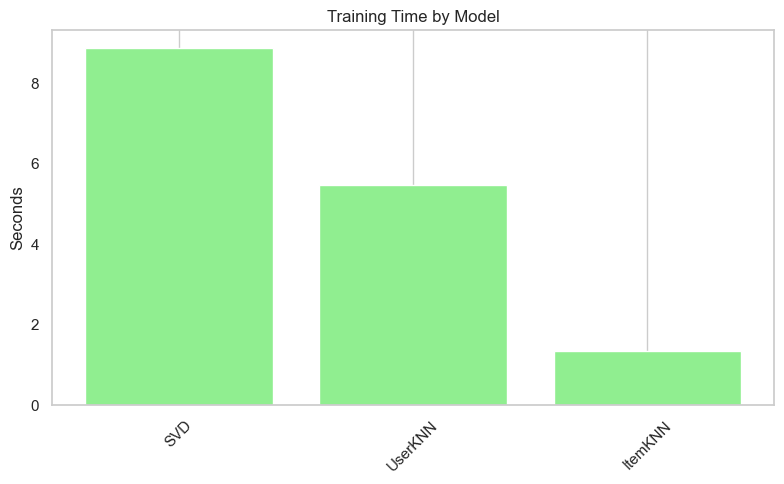

In [65]:
training_times = {
    'SVD': training_time,
    'UserKNN': 5.4736,
    'ItemKNN': 1.3446
}

models = list(training_times.keys())
times = list(training_times.values())

plt.figure(figsize=(8,5))
plt.bar(models, times, color='lightgreen')
plt.title('Training Time by Model')
plt.ylabel('Seconds')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


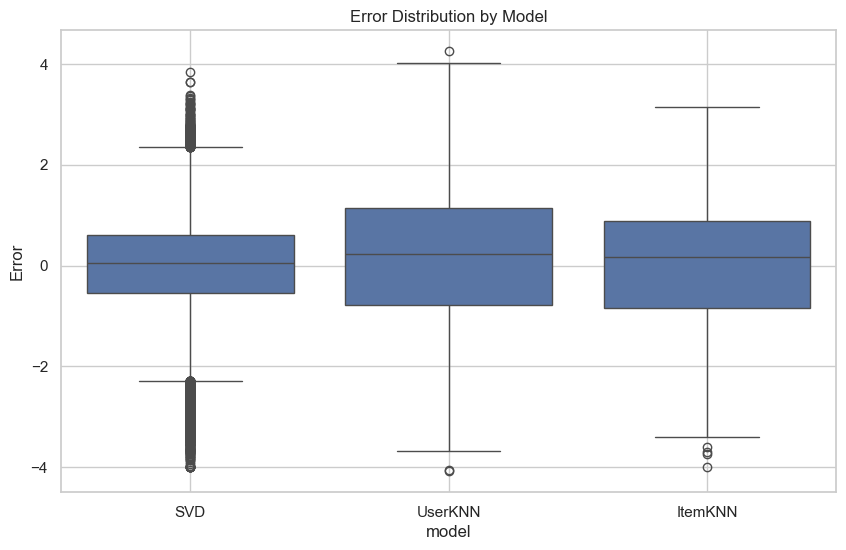

In [66]:
# Error distribution comparison

# Añadís el nombre del modelo a cada DataFrame
svd_errors['model'] = 'SVD'
uknn_errors['model'] = 'UserKNN'
iknn_errors['model'] = 'ItemKNN'

# Concatenás todo en un solo DataFrame
df_errores = pd.concat([svd_errors, uknn_errors, iknn_errors])

# Gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='error', data=df_errores)
plt.title('Error Distribution by Model')
plt.ylabel('Error')
plt.grid(True)
plt.show()